# CIFAR3 Calibration Benchmark

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary, plot_nll_curve
from calibrators import NiceCalibrator, PlanarFlowCalibrator, RadialFlowCalibrator, RealNvpCalibrator, TempScalingCalibrator, DummyCalibrator 

/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: P

In [4]:
# Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [5]:
%matplotlib inline
np.random.seed(1)

## Load data

In [6]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

In [7]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = np.argmax(target[random_split[:1500], :], axis=1)
test_target = np.argmax(target[random_split[1500:], :], axis=1)

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

### Visualize CIFAR3:

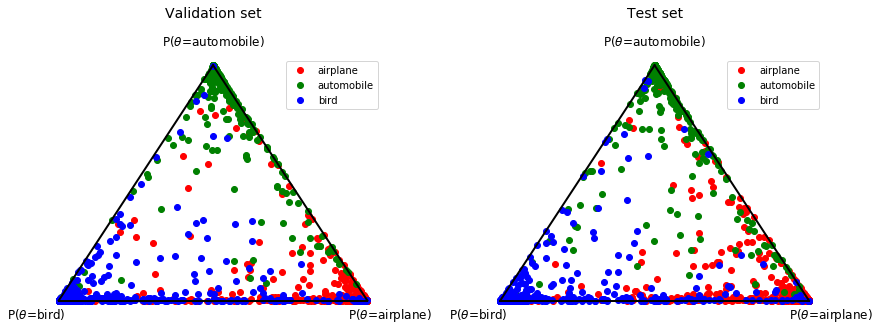

In [8]:
fig, ax_arr = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = plot_prob_simplex(softmax(val_logits, 1), val_target, ax=ax_arr[0],
                              title='Validation set', labels=list(ix2label.values()))
ax_arr[1] = plot_prob_simplex(softmax(test_logits, 1), test_target, ax=ax_arr[1],
                              title='Test set', labels=list(ix2label.values()))
plt.show()

<IPython.core.display.Javascript object>


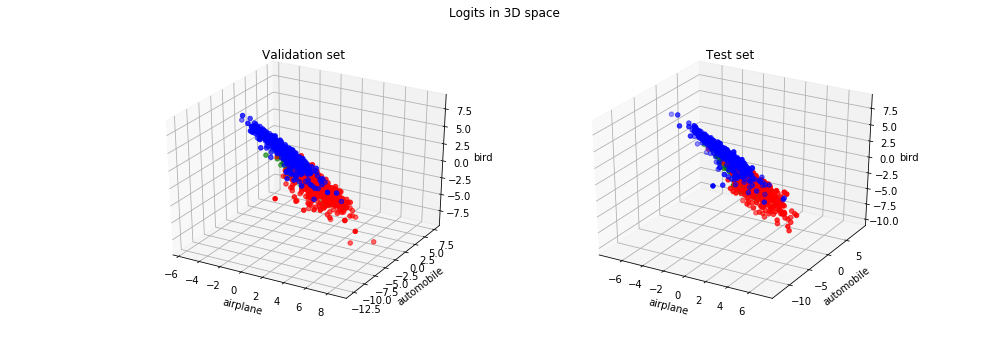

In [9]:
%matplotlib notebook  
%matplotlib notebook  
import matplotlib.pyplot as plt

colors = ['r', 'g', 'b']

fig = plt.figure(figsize=(14, 5))
fig.suptitle('Logits in 3D space', fontsize=12)
ax0 = fig.add_subplot(1,2,1, projection='3d')
ax1 = fig.add_subplot(1,2,2, projection='3d')

for i, c in enumerate(colors):
    
    ax0.scatter(val_logits[val_target==i, 0], val_logits[val_target==i, 1], val_logits[val_target==i, 2], c=c)
    ax1.scatter(test_logits[test_target==i, 0], test_logits[test_target==i, 1], test_logits[test_target==i, 2], c=c)
    
ax0.set_title('Validation set')
ax1.set_title('Test set')

ax0.set_xlabel(ix2label[0])
ax0.set_ylabel(ix2label[1])
ax0.set_zlabel(ix2label[2])

ax1.set_xlabel(ix2label[0])
ax1.set_ylabel(ix2label[1])
ax1.set_zlabel(ix2label[2])


plt.show();

### Helper methods:

In [10]:
def add_spoiling_samples(ax, pred_probs, target, probs):
    indv_nll = -np.sum(target*np.log(pred_probs+1e-7), axis=1)
    # spoiling_idx = np.argsort(indv_nll)[:-21:-1]
    spoiling_probs = probs[indv_nll>=np.log2(3), :]
    spoiling_target = np.argmax(target[indv_nll>=np.log2(3), :], axis=1)

    ax.scatter(spoiling_probs[spoiling_target==0, :]*ax._scale, s=50, color='red', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==1, :]*ax._scale, s=50, color='green', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==2, :]*ax._scale, s=50, color='blue', edgecolors='k', lw=1, zorder=2)
    
    return ax

In [11]:
def train_and_eval_cal(Calibrator):
    results = {}
    t = time.time()
    cal = Calibrator(val_logits, val_target)
    print('Calibrator fitted in {:.3f}s'.format(time.time()-t))
    results['nll_val'] = neg_log_likelihood(cal(val_logits), val_target)
    results['ece_val'] = expected_calibration_error(cal(val_logits), val_target)
    results['nll_test'] = neg_log_likelihood(cal(test_logits), test_target)
    results['ece_test'] = expected_calibration_error(cal(test_logits), test_target)
    results['cal'] = cal
    
    return results

## Train Calibrators

In [12]:
calibrators = {
    'Uncalibrated': DummyCalibrator,
    'Temp-Scaling': TempScalingCalibrator,
}

layers = [2, 6, 10, 20, 30]

nice_args = [
    {
        'layers': l,
        'hidden_size': [3, 3],
        'epochs': 1000,
        'batch_size': val_logits.shape[0],
    } for l in layers
]

nvp_args = [
    {
        'layers': l,
        'hidden_size': [3, 3],
        'epochs': 1000,
        'batch_size': val_logits.shape[0],
    } for l in layers
]

planar_args = [
    {
        'layers': l,
        'epochs': 1000,
        'batch_size': val_logits.shape[0],
    } for l in layers
]

radial_args = [
    {
        'layers': l,
        'epochs': 1000,
        'batch_size': val_logits.shape[0],
    } for l in layers
]



for nice in nice_args:
    name = 'NICE_l{}_hs{}'.format(nice['layers'], nice['hidden_size'])
    calibrators[name] = lambda logits, target: NiceCalibrator(logits, target, **nice)
    
for nvp in nvp_args:
    name = 'RealNVP_l{}_hs{}'.format(nvp['layers'], nvp['hidden_size'])
    calibrators[name] = lambda logits, target: RealNvpCalibrator(logits, target, **nvp)

for planar in planar_args:
    name = 'Planar_l{}'.format(planar['layers'])
    calibrators[name] = lambda logits, target: PlanarFlowCalibrator(logits, target, **planar)

for radial in radial_args:
    name = 'Radial_l{}'.format(radial['layers'])
    calibrators[name] = lambda logits, target: RadialFlowCalibrator(logits, target, **radial)

In [13]:
# Train all calibrators
results = {}
for name, Calibrator in calibrators.items():
    print('Training {:s}...'.format(name))
    results[name] = train_and_eval_cal(Calibrator)

Training Uncalibrated...
Calibrator fitted in 0.000s
Training Temp-Scaling...
Calibrator fitted in 0.010s
Training NICE_l2_hs[3, 3]...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Calibrator fitted in 38.148s
Training NICE_l6_hs[3, 3]...
Calibrator fitted in 38.267s
Training NICE_l10_hs[3, 3]...
Calibrator fitted in 40.078s
Training NICE_l20_hs[3, 3]...
Calibrator fitted in 40.535s
Training NICE_l30_hs[3, 3]...
Calibrator fitted in 44.351s
Training RealNVP_l2_hs[3, 3]...
Calibrator fitted in 80.244s
Training RealNVP_l6_hs[3, 3]...
Calibrator fitted in 87.413s
Training RealNVP_l10_hs[3, 3]...
Calibrator fitted in 94.668s
Training RealNVP_l20_hs[3, 3]...
Calibrator fitted in 100.619s
Training RealNVP_l30_hs[3, 3]...
Calibrator fitted in 111.837s
Training Planar_l2...
Calibrator fitted in 73.674s
Training Planar_l6...
Calibrator fitted in 74.876s
Training Planar_l10...
Calibrator fitted in 76.896s
Training Planar_l

In [15]:
results['RealNVP_l20_hs[3, 3]']['cal'].history.history['loss']

[1.4639198780059814,
 1.3041365146636963,
 1.1666291952133179,
 1.0694327354431152,
 1.0048304796218872,
 0.9594285488128662,
 0.9256163835525513,
 0.8995254635810852,
 0.8774725198745728,
 0.856452465057373,
 0.8368933200836182,
 0.8187634348869324,
 0.8015704154968262,
 0.7835004925727844,
 0.7651481032371521,
 0.7474688291549683,
 0.7293104529380798,
 0.7105249166488647,
 0.6924460530281067,
 0.675334632396698,
 0.6577087044715881,
 0.6409235596656799,
 0.624538004398346,
 0.6088637113571167,
 0.5931422710418701,
 0.5778666734695435,
 0.5627366304397583,
 0.5484188795089722,
 0.5346717834472656,
 0.5204984545707703,
 0.507934033870697,
 0.4975978136062622,
 0.48798680305480957,
 0.4790419638156891,
 0.47046613693237305,
 0.46129110455513,
 0.4510544538497925,
 0.44083788990974426,
 0.4322490692138672,
 0.4247894287109375,
 0.41781726479530334,
 0.4105760455131531,
 0.4036123752593994,
 0.3956097364425659,
 0.38691577315330505,
 0.3805692493915558,
 0.37603050470352173,
 0.3714858293

In [18]:
plt.plot(results['RealNVP_l20_hs[3, 3]']['cal'].history.history['loss'])

TypeError: plot() missing 1 required positional argument: 'ys'

## Comparing flows:

### Overfitting:

Text(0.5, 1.0, 'ECE Flows')

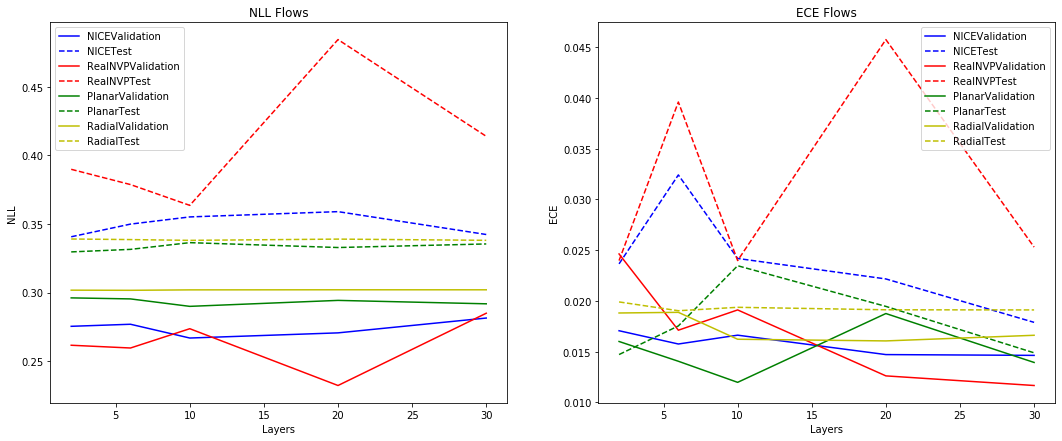

In [21]:
colors = ['b', 'r', 'g', 'y']
flows = ['NICE_l{}_hs[3, 3]', 'RealNVP_l{}_hs[3, 3]', 'Planar_l{}', 'Radial_l{}']
%matplotlib inline

fig, ax_arr = plt.subplots(1, 2, figsize=(18, 7))

for color, flow in zip(colors, flows):
    ## NICE
    val_nll = []
    test_nll = []
    val_ece = []
    test_ece = []
    for l in layers:
        val_nll.append(results[flow.format(l)]['nll_val'])
        test_nll.append(results[flow.format(l)]['nll_test'])
        val_ece.append(results[flow.format(l)]['ece_val'])
        test_ece.append(results[flow.format(l)]['ece_test'])
    ax_arr[0].plot(layers, val_nll, color, label=flow.split('_')[0] + 'Validation')
    ax_arr[0].plot(layers, test_nll, color + '--', label=flow.split('_')[0] + 'Test')

    ax_arr[1].plot(layers, val_ece, color, label=flow.split('_')[0] + 'Validation')
    ax_arr[1].plot(layers, test_ece, color + '--', label=flow.split('_')[0] + 'Test')


ax_arr[0].legend()
ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('Layers')
ax_arr[0].set_title('NLL Flows')

ax_arr[1].legend()
ax_arr[1].set_ylabel('ECE')
ax_arr[1].set_xlabel('Layers')
ax_arr[1].set_title('ECE Flows')